In [16]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import joblib

In [5]:
data = pd.read_csv("SBER(2015-2025).csv")
data = data.replace('nan', np.nan)
data['Объём'] = data['Объём'].fillna(0)
data = data.iloc[::-1].reset_index(drop=True)
data

,Дата,Цена,Откр.,Макс.,Мин.,Объём,Изм. %
0,26.01.2015,"60,49","63,79","63,88","60,17","154,04M","-6,14%"
1,27.01.2015,"61,20","58,20","61,44","57,20","188,57M","1,17%"
2,28.01.2015,"60,63","61,81","62,58","60,31","139,31M","-0,93%"
3,29.01.2015,"60,50","60,40","62,00","59,60","150,53M","-0,21%"
4,30.01.2015,"61,50","61,25","61,50","59,67","194,98M","1,65%"
...,...,...,...,...,...,...,...
2515,20.01.2025,"278,19","285,10","286,23","277,61","67,95M","-1,88%"
2516,21.01.2025,"281,85","279,39","281,85","276,32","40,48M","1,32%"
2517,22.01.2025,"280,36","282,00","284,00","280,20","47,11M","-0,53%"
2518,23.01.2025,"280,49","280,79","280,79","277,35","38,57M","0,05%"


In [6]:
for i in range(len(data)):
  data.loc[i, "Цена"] = data.loc[i, "Цена"].replace(",", ".")
  data.loc[i, "Откр."] = data.loc[i, "Откр."].replace(",", ".")
  data.loc[i, "Макс."] = data.loc[i, "Макс."].replace(",", ".")
  data.loc[i, "Мин."] = data.loc[i, "Мин."].replace(",", ".")
  data.loc[i, "Изм. %"] = data.loc[i, "Изм. %"].replace(",", ".")
  data.loc[i, "Изм. %"] = data.loc[i, "Изм. %"].replace("%", "")
  data.loc[i, "Объём"] = str(data.loc[i, "Объём"]).replace(",", ".")
  if 'M' in  data.loc[i, "Объём"]:
   data.loc[i, "Объём"] = str(data.loc[i, "Объём"]).replace("M", "")
  elif 'B' in data.loc[i, "Объём"]:
    data.loc[i, "Объём"] = str(data.loc[i, "Объём"]).replace("B", "")

columns_to_convert = ['Цена', 'Откр.', 'Макс.', 'Мин.', 'Объём', 'Изм. %']
# Преобразуем строки в числа, заменяя некорректные значения на NaN
for col in columns_to_convert:
    data[col] = pd.to_numeric(data[col], errors='coerce')


In [7]:
data

,Дата,Цена,Откр.,Макс.,Мин.,Объём,Изм. %
0,26.01.2015,60.49,63.79,63.88,60.17,154.04,-6.14
1,27.01.2015,61.20,58.20,61.44,57.20,188.57,1.17
2,28.01.2015,60.63,61.81,62.58,60.31,139.31,-0.93
3,29.01.2015,60.50,60.40,62.00,59.60,150.53,-0.21
4,30.01.2015,61.50,61.25,61.50,59.67,194.98,1.65
...,...,...,...,...,...,...,...
2515,20.01.2025,278.19,285.10,286.23,277.61,67.95,-1.88
2516,21.01.2025,281.85,279.39,281.85,276.32,40.48,1.32
2517,22.01.2025,280.36,282.00,284.00,280.20,47.11,-0.53
2518,23.01.2025,280.49,280.79,280.79,277.35,38.57,0.05


In [8]:
features = ['Откр.', "Макс.", "Мин.", "Объём", "Изм. %"]
target = 'Цена'

In [9]:
# Стандартизация целевой переменной
scaler_target = StandardScaler()
scaled_target = scaler_target.fit_transform(data[[target]])  # Обратите внимание на двойные скобки [[target]]

# Стандартизация признаков
scaler_features = StandardScaler()
scaled_features = scaler_features.fit_transform(data[features])

# Объединение стандартизированных данных
scaled_data = np.hstack([scaled_features, scaled_target])

In [10]:


# Преобразование в тензоры PyTorch
X = torch.tensor(scaled_features, dtype=torch.float32)
y = torch.tensor(scaled_target, dtype=torch.float32)

# Разделение на обучающую и тестовую выборки
train_size = int(len(X) * 0.8)
train_X, test_X = X[:train_size], X[train_size:]
train_y, test_y = y[:train_size], y[train_size:]

# Создание DataLoader
train_dataset = TensorDataset(train_X, train_y)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [11]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2, dropout=0.5):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers)
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(hidden_size, 64)  # Учитываем bidirectional
        self.fc2 = nn.Linear(64, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, self.hidden_size).to(x.device)  # Учитываем bidirectional
        c0 = torch.zeros(self.num_layers, self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = out[:, :]  # Берём последний временной шаг
        out = self.dropout(out)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out

model = LSTMModel(input_size=len(features), hidden_size=50, output_size=1, num_layers=1)

In [12]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Обучение
for epoch in range(20):
    model.train()
    for batch_X, batch_y in train_loader:
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Градиентный клиппинг
        optimizer.step()

    print(f'Epoch [{epoch+1}/100], Loss: {loss.item():.4f}')

Epoch [1/100], Loss: 0.0983
Epoch [2/100], Loss: 0.0304
Epoch [3/100], Loss: 0.0382
Epoch [4/100], Loss: 0.0314
Epoch [5/100], Loss: 0.0372
Epoch [6/100], Loss: 0.0500
Epoch [7/100], Loss: 0.0326
Epoch [8/100], Loss: 0.0208
Epoch [9/100], Loss: 0.0213
Epoch [10/100], Loss: 0.0140
Epoch [11/100], Loss: 0.0291
Epoch [12/100], Loss: 0.0212
Epoch [13/100], Loss: 0.0097
Epoch [14/100], Loss: 0.0154
Epoch [15/100], Loss: 0.0349
Epoch [16/100], Loss: 0.0143
Epoch [17/100], Loss: 0.0190
Epoch [18/100], Loss: 0.0174
Epoch [19/100], Loss: 0.0224
Epoch [20/100], Loss: 0.0168


Test Loss: 0.0012


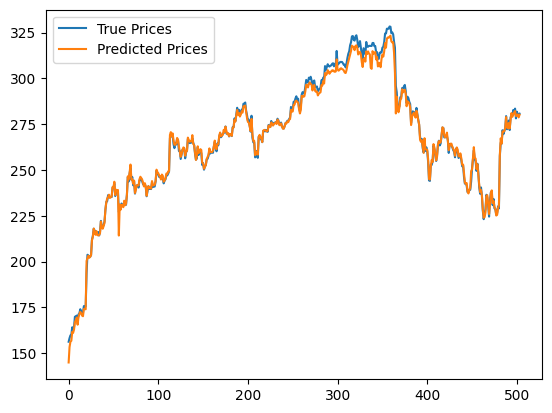

In [13]:
model.eval()

# Вычисляем предсказания на тестовых данных
with torch.no_grad():
    test_outputs = model(test_X)
    test_loss = criterion(test_outputs, test_y)
    print(f'Test Loss: {test_loss.item():.4f}')

# Обратное преобразование целевой переменной
true_prices = scaler_target.inverse_transform(test_y.reshape(-1, 1))
predicted_prices = scaler_target.inverse_transform(test_outputs.numpy().reshape(-1, 1))
# Визуализация результатов
plt.plot(true_prices, label='True Prices')
plt.plot(predicted_prices, label='Predicted Prices')
plt.legend()
plt.show()

In [14]:
torch.save(model, 'lstm_model.pth')

In [18]:
joblib.dump(scaler_features, 'scaler_features.pkl')
joblib.dump(scaler_target, 'scaler_target.pkl')

['scaler_target.pkl']